# 상점 신용카드 매출 예측 경진대회
**20180794 정영주**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pmdarima as pm
import pmdarima
import statsmodels
import rpy2
import rpy2.robjects as robjects  # R 함수를 쓰기위한 패키지
from tqdm import tqdm
from rpy2.robjects import pandas2ri # pandas를 R 데이터로 형식으로 변환하기 위한 패키지 
from rpy2.robjects.packages import importr # R 패키지를 import 한다
from pmdarima.arima.stationarity import ADFTest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

warnings.filterwarnings("ignore")

print('Numpy: %s'%(np.__version__))
print('Pandas: %s'%(pd.__version__))
print('pmdarima: %s'%(pmdarima.__version__))
print('seaborn: %s'%(sns.__version__))
print('statsmodel: %s'%(statsmodels.__version__))
print('matplotlib: %s'%(matplotlib.__version__))
print('rpy2: %s'%(rpy2.__version__))

Numpy: 1.18.5
Pandas: 1.1.2
pmdarima: 1.8.0
seaborn: 0.11.0
statsmodel: 0.12.2
matplotlib: 3.3.2
rpy2: 3.4.3


In [2]:
utils = importr('utils') # utils 패키지 import
utils.install_packages('forecast') # R의 forecast패키지 설치
utils.install_packages('forecastHybrid') # R의 forecastHybrid패키지 설치

--- 현재 세션에서 사용할 CRAN 미러를 선택해 주세요 ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Australia (Perth) [https]
 6: Austria [https]
 7: Brazil (BA) [https]
 8: Brazil (PR) [https]
 9: Brazil (RJ) [https]
10: Brazil (SP 1) [https]
11: Brazil (SP 2) [https]
12: Bulgaria [https]
13: Canada (MB) [https]
14: Chile (Santiago) [https]
15: China (Beijing 2) [https]
16: China (Hefei) [https]
17: China (Hong Kong) [https]
18: China (Guangzhou) [https]
19: China (Lanzhou) [https]
20: China (Nanjing) [https]
21: China (Shanghai 1) [https]
22: China (Shanghai 2) [https]
23: Costa Rica [https]
24: Denmark [https]
25: East Asia [https]
26: Ecuador (Cuenca) [https]
27: Ecuador (Quito) [https]
28: Estonia [https]
29: France (Lyon 1) [https]
30: France (Lyon 2) [https]
31: France (Marseille) [https]
32: France (Montpellier) [https]
33: Germany (Erlangen) [https]
34: Germany (Leipzig) [https]
35: Germany

선택:  48


R[write to console]: URL 'https://cran.seoul.go.kr/bin/macosx/contrib/4.0/forecast_8.14.tgz'을 시도합니다

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 2368325 bytes (2.3 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write t


다운로드된 바이너리 패키지들은 다음의 위치에 있습니다
	/var/folders/4c/mzcsk3jd4bx053t6khbcnjj80000gn/T//Rtmpd0h9RY/downloaded_packages


R[write to console]: URL 'https://cran.seoul.go.kr/bin/macosx/contrib/4.0/forecastHybrid_5.0.19.tgz'을 시도합니다

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 674646 bytes (658 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[


다운로드된 바이너리 패키지들은 다음의 위치에 있습니다
	/var/folders/4c/mzcsk3jd4bx053t6khbcnjj80000gn/T//Rtmpd0h9RY/downloaded_packages


<rpy2.rinterface_lib.sexp.NULLType object at 0x7fb141ffea00> [RTYPES.NILSXP]

## 1. 데이터 불러오기 및 확인

#### ① 데이터 불러오기

In [3]:
pandas2ri.activate() # 모델링시 판다스를 R 데이터로 변환하기위해 activate 시켜야한다!
train = pd.read_csv('./data09/funda_train.csv')
submission = pd.read_csv('./data09/submission.csv')

In [4]:
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


#### ② 변수 확인

- **store_id**: 상점의 고유 아이디
- **card_id**: 사용한 카드의 고유 아이디
- **card_company**: 비식별화된 카드 회사
- **transacted_date**: 거래 날짜
- **transacted_time**: 거래 시간(시:분)
- **installment_term**: 할부 개월 수(포인트 사용 시 '60개월 + 실제할부개월'을 할부개월수에 기재)
- **region**: 상점의 지역
- **type_of_business**: 상점의 업종
- **amount**: 거래액 (단위는 '원'이 아님)

#### ③ 결측값 수 확인

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

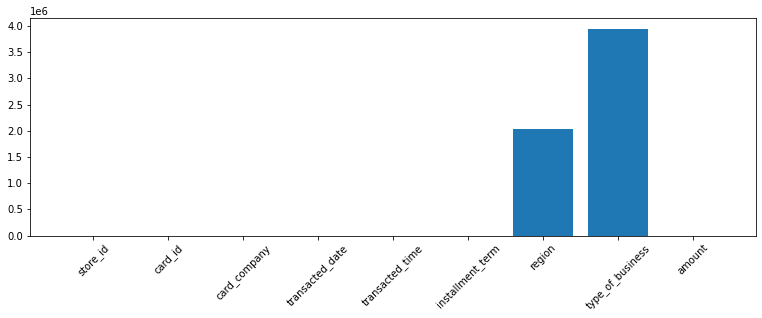

In [5]:
plt.figure(figsize=(13, 4))
plt.bar(train.columns, train.isnull().sum())
plt.xticks(rotation=45)

**결측값의 수가 높게 나온 'region' 칼럼과 'type_of_business' 칼럼을 제거한다**

In [6]:
train=train.drop(['region','type_of_business'],axis=1)
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
0,0,0,b,2016-06-01,13:13,0,1857.142857
1,0,1,h,2016-06-01,18:12,0,857.142857
2,0,2,c,2016-06-01,18:52,0,2000.000000
3,0,3,a,2016-06-01,20:22,0,7857.142857
4,0,4,c,2016-06-02,11:06,0,2000.000000


## 2. 데이터 전처리

#### ① datetime 칼럼 생성

In [9]:
train['datetime'] = pd.to_datetime(train.transacted_date + " " + 
                                train.transacted_time, format='%Y-%m-%d %H:%M:%S')

In [10]:
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
0,0,0,b,2016-06-01,13:13,0,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,2000.000000,2016-06-02 11:06:00


#### ② amount 칼럼 확인 & 노이즈 제거

<AxesSubplot:xlabel='amount'>

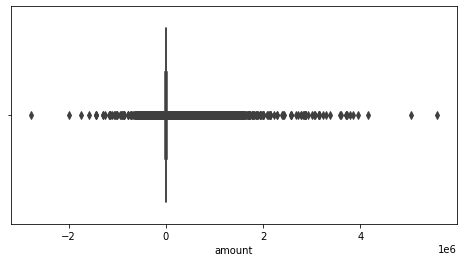

In [7]:
plt.figure(figsize=(8, 4))
sns.boxplot(train['amount'])

In [8]:
train[train['amount']<0].head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
41,0,40,a,2016-06-10,17:26,2,-8571.428571
347,0,285,a,2016-08-04,17:52,0,-1857.142857
731,0,473,g,2016-10-17,10:32,0,-2000.000000
831,0,230,b,2016-11-03,15:36,0,-85.714286
944,0,138,a,2016-11-28,13:21,0,-57.142857


**amount(거래액) 칼럼에서 보이는 음수값은 환불금액으로 예상된다!**

- 환불한 경우는 log를 취했을 때 무한대 값이 나오기 때문에 제거하는 것이 낫다고 판단
- 환불발생 이전 데이터 중 card_id가 같고 amount의 절댓값이 같은 후보 리스트를 찾은 후, 가장 최근 시간의 것을 제거하자

In [12]:
## 함수 생성

def refund_remove(df):
    
    # 환불 여부에 따라 데이터 나누기
    refund=df[df['amount']<0]
    non_refund=df[df['amount']>0]
    remove_data=pd.DataFrame()
    
    for i in tqdm(df.store_id.unique()):
        divided_data=non_refund[non_refund['store_id']==i] # non_refund 스토어 데이터를 스토어별로 나누기
        divided_data2=refund[refund['store_id']==i] # refund 스토어 데이터를 스토어별로 나누기
        
        for neg in divided_data2.to_records()[:]: # 환불데이터를 차례대로 검사
            refund_store=neg['store_id']
            refund_id=neg['card_id'] # 환불 카드 아이디
            refund_datetime=neg['datetime'] # 환불 시간
            refund_amount=abs(neg['amount']) # 환불액에 절대값 씌운 것
                
            # 환불시간 이전의 데이터중 카드아이디와 환불액이 같은 후보 리스트 뽑기
            refund_pay_list=divided_data[divided_data['datetime']<=refund_datetime]
            refund_pay_list=refund_pay_list[refund_pay_list['card_id']==refund_id]
            refund_pay_list=refund_pay_list[refund_pay_list['amount']==refund_amount]
                
                
            # 후보리스트가 있으면 카드아이디, 환불액이 같으면서 가장 최근시간을 제거
            if(len(refund_pay_list)!=0):
                refund_datetime=max(refund_pay_list['datetime']) # 가장 최근 시간을 구한기
                remove=divided_data[divided_data['datetime']==refund_datetime] # 가장 최근시간
                remove=remove[remove['card_id']==refund_id] # 환불 카드 아이디
                remove=remove[remove['amount']==refund_amount] # 환불액
                divided_data=divided_data.drop(index=remove.index) # 인덱스를 통해 제거
                    
        # 제거한 데이터를 데이터프레임에 추가
        remove_data=pd.concat([remove_data,divided_data],axis=0)
    
    return remove_data

In [13]:
train_remove=refund_remove(train)

100%|██████████| 1967/1967 [12:37<00:00,  2.60it/s]


<AxesSubplot:xlabel='amount'>

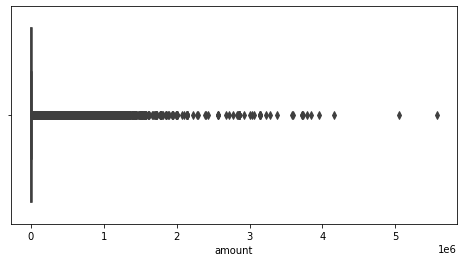

In [14]:
plt.figure(figsize=(8, 4))
sns.boxplot(train_remove['amount'])

**환불금액이 잘 제거되었다!**

#### ③ 다운샘플링

In [15]:
## 월별로 다운 샘플링해주는 함수 생성

def month_resampling(df):
    
    new_data=pd.DataFrame() 
    df['year_month']=df['transacted_date'].str.slice(stop=7)
    year_month=df['year_month'].drop_duplicates() # 중복값을 drop한다!
    
    downsampling_data=df.groupby(['store_id', 'year_month']).amount.sum()
    downsampling_data=pd.DataFrame(downsampling_data)
    downsampling_data=downsampling_data.reset_index(drop=False,inplace=False)
    
    for i in tqdm(df.store_id.unique()):
        store=downsampling_data[downsampling_data['store_id']==i]
        start_time=min(store['year_month'])
        store=store.merge(year_month,how='outer')
        store=store.sort_values(by=['year_month'], axis=0, ascending=True) # 데이터를 시간순으로 정렬
        
        store['amount']=store['amount'].fillna(2)   # 매출이 발생하지 않는 월은 2로 채우기
        store['store_id']=store['store_id'].fillna(i) # store_id 결측치 채우기
        store=store[store['year_month']>=start_time]  # 매출 시작일 이후만 뽑기
        
        new_data=pd.concat([new_data,store],axis=0)
        
    return new_data

In [16]:
# 월별로 데이터 다운샘플링 시행

resampling_data=month_resampling(train_remove)
resampling_data['store_id']=resampling_data['store_id'].astype(int)
pd.set_option('display.float_format', '{:.2f}'.format)
resampling_data

100%|██████████| 1967/1967 [00:10<00:00, 185.85it/s]


,store_id,year_month,amount
0,0,2016-06,747000.00
1,0,2016-07,1005000.00
2,0,2016-08,869714.29
3,0,2016-09,897857.14
4,0,2016-10,835428.57
...,...,...,...
17,2136,2018-10,2012214.29
18,2136,2018-11,2127642.86
19,2136,2018-12,2427428.57
20,2136,2019-01,1867785.71


#### ④ 상점별 Series 데이터로 변환 & 시각화

In [18]:
## Series 데이터로 변환해주는 함수 생성

def time_series(df,i):
    
    store=df[df['store_id']==i]
    index=pd.date_range(min(store['year_month']),'2019-03',freq='BM') # 영업 시작일부터 2019년 2월까지 데이터 존재
    ts=pd.Series(store['amount'].values,index=index)
    
    return ts

In [19]:
store_0=time_series(resampling_data,0) # store_id == 0인 경우
store_1=time_series(resampling_data,1) # store_id == 1인 경우
store_2=time_series(resampling_data,2) # store_id == 2인 경우

<class 'pandas.core.series.Series'>


<AxesSubplot:>

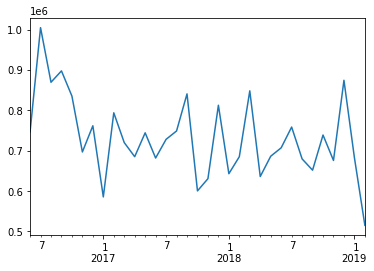

In [23]:
store_0.plot()

<AxesSubplot:>

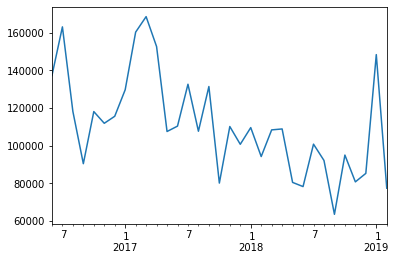

In [24]:
store_1.plot()

<AxesSubplot:>

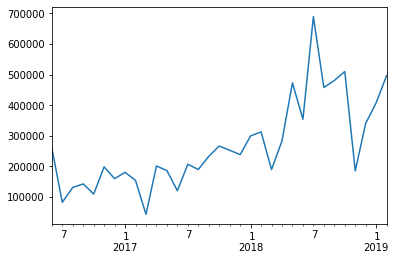

In [25]:
store_2.plot()

## 3. 탐색적 자료분석 (EDA)

#### ① 각 상점별 매출 그래프

In [26]:
## 상점 매출 시계열 그래프 출력 함수 생성

def store_plot(data,start_id,end_id):
    
    plt.figure(figsize=(15, 6))
    
    for i in data['store_id'].unique()[start_id:end_id]:
        plt.plot(data[data['store_id']== i].index, data[data['store_id'] == i].amount, label='store_{}'.format(i))
        
    plt.legend()   

In [27]:
## 상점별 매출 분포 출력 함수 생성

def store_displot(data,start_id,end_id):
    
    plt.figure(figsize=(15, 6))
    
    for i in data.store_id.unique()[start_id:end_id]:
        sns.distplot(data[data.store_id == i].amount)
        
    plt.grid()
    plt.show()

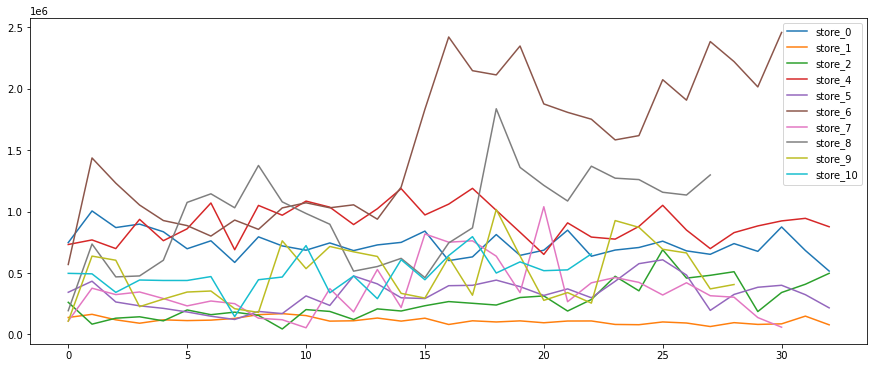

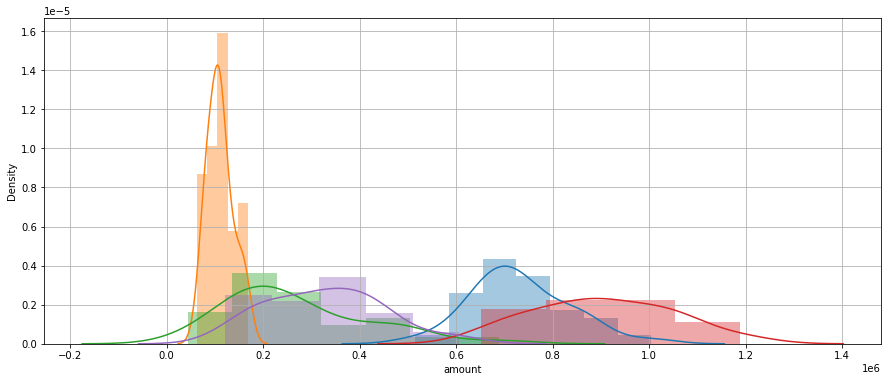

In [28]:
# 그래프 출력

store_plot(resampling_data,0,10)
store_displot(resampling_data,0,5)

**각 상점별 매출 특성과 분포가 다르므로 개별적인 시계열 모델링이 필요해 보인다!**

In [ ]:
##ARIMA 모형의 차분 여부를 결정하기 위한 단위근 검정
def adf_test(y):
    adf_test = ADFTest(alpha=0.05)
    p_val, should_diff = adf_test.should_diff(y)
    return p_val

In [ ]:
##acf. pacf 그래프
def acf_pacf_plot(data=None,store_id=None):
    ts=time_series(data,store_id)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    plot_acf(ts,lags=20,ax=ax1)
    ax2 = fig.add_subplot(212)
    plot_pacf(ts, lags=20, ax=ax2)

In [ ]:
##매출 변동계수를 구하는 함수
def coefficient_variation(df,i):
    cv_data=df.groupby(['store_id']).amount.std()/df.groupby(['store_id']).amount.mean()
    cv=cv_data[i]
    return cv

참고코드: https://dacon.io/competitions/official/140472/overview/description/